In [ ]:
import sys

sys.path.append('../../')

import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras.backend as K
from keras.layers import Dense, Conv1D, MaxPool1D, Lambda
from keras import Input, Model
from keras import Sequential

from Pipeline.Multi_task.mmoe import MultiGateMixtureOfExperts
from Pipeline.tf_dataset_builder import DatasetBuilderRaw
from Pipeline.evaluation import detection_report
from Pipeline.tf_lite_utils import convert_tf_lite_mtl, predict_tflite_mtl, convert_tf_lite, compare_size
from Pipeline.evaluation import plot_confusion_matrix

In [3]:
# Set seed for experiment reproducibility
seed = 1
tf.random.set_seed(seed)

In [4]:
# Define paths to model files
MODELS_DIR = '../../Models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'mmoe_model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'mmoe_model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'mmoe_model.tflite'

In [5]:
class_dict = {
    'Background': 0,
    'Big mandibles': 1,
    'Small mandibles': 2,
}

In [6]:
# Set hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
patience = 10

# Loss weighting parameter
gamma = 0.5

# Mixture of experts parameters
n_experts = 3
n_tasks = 2
include_base_layer = True

In [7]:
# Load the data: raw extraction
DatasetBuilder = DatasetBuilderRaw(
    #dataset_dir="../../Dataset/Generated dataset/Deployment/unstandardized/50ms/**/*.wav",
    dataset_dir="../../Dataset/Final dataset/Generation/Generated dataset/**/*.wav",
    batch_size=batch_size,
    class_dict=class_dict,
    augment=False,
    balanced=False,
    multi_task=True,
    normalize=True,
    seed=seed,
    sample_rate=44100
)
train_dataset, val_dataset, test_dataset = DatasetBuilder.build(val_split=0.2, test_split=0.2)

In [8]:
input_shape = test_dataset[0][0].shape
input_shape

(2205, 1)

In [9]:
# define experts: each expert is dense layer with user defined
# activation function
experts = [Dense(10, activation="relu") for _ in range(n_experts)]

# task layers: each task layer is a dense layer with user defined
# activation function
detection_head = Sequential([
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
detection_head._name = 'detection'

classification_head = Sequential([
    Dense(32, activation='relu'),
    Dense(len(class_dict), activation='softmax'),
])
classification_head._name = 'classification'

task_layers = [detection_head, classification_head]

# adding base / preprocessing layer
base_layer = None
if include_base_layer:
    base_layer = Sequential([
        Conv1D(filters=8, kernel_size=80, padding="same", activation='relu'),
        MaxPool1D(pool_size=4, strides=2),
        Conv1D(filters=8, kernel_size=3, padding="same", activation='relu'),
        MaxPool1D(pool_size=4, strides=2),
        Conv1D(filters=8, kernel_size=3, padding="same", activation='relu'),
        MaxPool1D(pool_size=4, strides=2),
        Lambda(lambda x: K.mean(x, axis=1)),
        #Dense(32, activation='relu'),
    ])

# combine everything using Multi Gate Mixture of Experts layer
mmoe = MultiGateMixtureOfExperts(experts,
                                 task_layers,
                                 moe_dropout=True,
                                 moe_dropout_rate=0.15,
                                 base_layer=base_layer)


# create tf.keras Model using functional API
input_layer = Input(shape=input_shape)
output_layer = mmoe(input_layer)
multitask_model = Model(inputs=input_layer, outputs=output_layer)

In [10]:
multitask_model.summary(expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2205, 1)]         0         
                                                                 
 multi_gate_mixture_of_exper  [(None, 1),              2208      
 ts (MultiGateMixtureOfExper   (None, 3)]                        
 ts)                                                             
                                                                 
Total params: 2,208
Trainable params: 2,208
Non-trainable params: 0
_________________________________________________________________


In [11]:
loss1 = tf.keras.losses.BinaryCrossentropy()
loss2 = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

losses = {
    'multi_gate_mixture_of_experts': loss1,
    'multi_gate_mixture_of_experts_1': loss2
}

loss_weights = {
    'multi_gate_mixture_of_experts': gamma,
    'multi_gate_mixture_of_experts_1': 1 - gamma
}

metrics = ['accuracy']

multitask_model.compile(
    optimizer=optimizer,
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics,
)

In [12]:
#rename true labels
train_dataset = train_dataset.map(lambda x, y: (x, {'multi_gate_mixture_of_experts': y['detection'], 'multi_gate_mixture_of_experts_1': y['classification']}))

val_dataset = val_dataset.map(lambda x, y: (x, {'multi_gate_mixture_of_experts': y['detection'], 'multi_gate_mixture_of_experts_1': y['classification']}))

In [13]:
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(verbose=1, patience=patience)

history = multitask_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/100
30/30 [==============================] - 4s 61ms/step - loss: 0.8809 - multi_gate_mixture_of_experts_loss: 0.6555 - multi_gate_mixture_of_experts_1_loss: 1.1063 - multi_gate_mixture_of_experts_accuracy: 0.6583 - multi_gate_mixture_of_experts_1_accuracy: 0.3250 - val_loss: 0.8661 - val_multi_gate_mixture_of_experts_loss: 0.6320 - val_multi_gate_mixture_of_experts_1_loss: 1.1002 - val_multi_gate_mixture_of_experts_accuracy: 0.6708 - val_multi_gate_mixture_of_experts_1_accuracy: 0.3292 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 0.8721 - multi_gate_mixture_of_experts_loss: 0.6436 - multi_gate_mixture_of_experts_1_loss: 1.1006 - multi_gate_mixture_of_experts_accuracy: 0.6583 - multi_gate_mixture_of_experts_1_accuracy: 0.3313 - val_loss: 0.8627 - val_multi_gate_mixture_of_experts_loss: 0.6246 - val_multi_gate_mixture_of_experts_1_loss: 1.1009 - val_multi_gate_mixture_of_experts_accuracy: 0.6708 - val_multi_gate_mixture_of_experts_1_accu

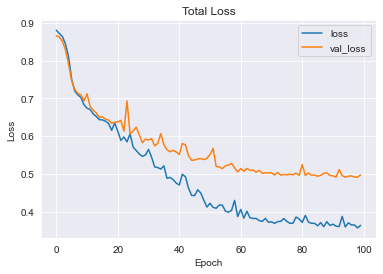

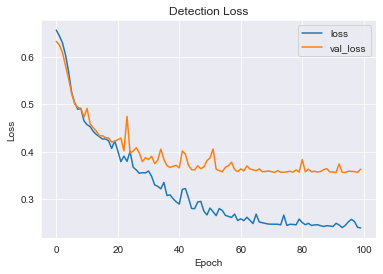

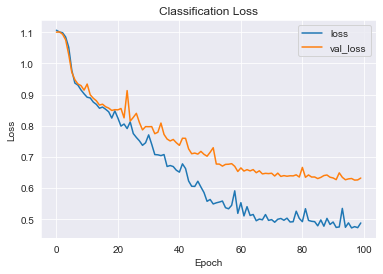

In [14]:
metrics = history.history
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.title('Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['multi_gate_mixture_of_experts_loss'], metrics['val_multi_gate_mixture_of_experts_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['multi_gate_mixture_of_experts_1_loss'], metrics['val_multi_gate_mixture_of_experts_1_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [15]:
test_features = test_dataset[0]
predictions = multitask_model.predict(test_features, verbose=1)

y_pred = np.rint(predictions[0]).astype(int).flatten()
y_true = test_dataset[1]['detection']

detection_report(y_true, y_pred)

19/19 [==============================] - 0s 7ms/step

Evaluation on the test set:
False alarm prob: 20.43%
Miss detection prob: 15.94%
Number of False Positives: 38
Number of False Negatives: 66
Detector f1-score is 87.000000%

Other Metrics:
Detector accuracy is 82.666667%
Detector precision is 90.155440%
Detector recall is 84.057971%


              precision    recall  f1-score   support

           0     0.6408    0.8441    0.7285       186
           1     0.8025    0.6117    0.6942       206
           2     0.7323    0.6971    0.7143       208

    accuracy                         0.7133       600
   macro avg     0.7252    0.7176    0.7123       600
weighted avg     0.7281    0.7133    0.7118       600



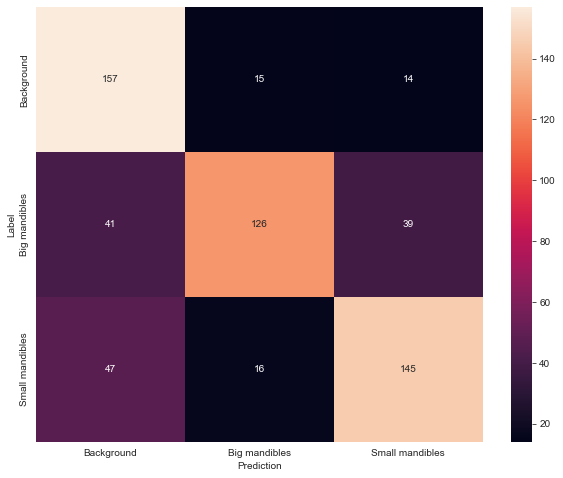

In [16]:
y_pred = np.argmax(predictions[1], axis=1)
y_true = test_dataset[1]['classification']

print(classification_report(y_true, y_pred, digits=4))
plot_confusion_matrix(list(class_dict.keys()), y_true, y_pred)

In [17]:
multitask_model.save(MODEL_TF)
convert_tf_lite(MODEL_TF, MODEL_NO_QUANT_TFLITE)

INFO:tensorflow:Assets written to: ../../Models/mmoe_model\assets


INFO:tensorflow:Assets written to: ../../Models/mmoe_model\assets


Float model is 30280 bytes


In [18]:
def representative_dataset():
    for feature, label in train_dataset.take(100):
        yield {
            "input_1": feature.numpy(),
            # "detection": label['multi_gate_mixture_of_experts'].numpy(),
            # "classification": label['multi_gate_mixture_of_experts_1'].numpy(),
        }

In [19]:
# Define the input and output details for TensorFlow Lite
input_details = multitask_model.input
output_details = [multitask_model.output[0], multitask_model.output[1]]
# Convert to TensorFlow Lite model
convert_tf_lite_mtl(MODEL_TF, MODEL_TFLITE, representative_dataset, output_details)

Quantized model is 28480 bytes


In [20]:
compare_size(multitask_model, batch_size, MODEL_NO_QUANT_TFLITE, MODEL_TFLITE)

,Size,
Model,,
TensorFlow,566944 bytes,
TensorFlow Lite,30280 bytes,(reduced by 536664 bytes)
TensorFlow Lite Quantized,28480 bytes,(reduced by 1800 bytes)


In [ ]:
y_pred_det, y_pred_class = predict_tflite_mtl(MODEL_TFLITE, test_features)

print('%s model detection accuracy is %f%% (Number of test samples=%d)' % (
    'Quantized', accuracy_score(test_dataset[1]['detection'], y_pred_det) * 100, len(test_features)))

In [ ]:
print(classification_report(test_dataset[1]['classification'], y_pred_class, digits=4))
plot_confusion_matrix(list(class_dict.keys()), test_dataset[1]['classification'], y_pred_class)